# Data analysis - Dutch census

This notebook analyses the dataset *Dutch census*, available from [GitHub](https://github.com/alku7660/counterfactual-fairness/blob/main/Datasets/dutch/preprocessed_dutch.csv). You have to download it and upload it to the GoogleColab session storage using the File>Upload option.

This notebook is part of the tutorial **A hands-on tutorial on explainable methods for machine learning with Python: applications to gender bias**, 3rd EuADS Summer School – Data Science for Explainable and Trustworthy AI (7-9 June 2023)

Author: Aurora Ramírez (University of Córdoba)

## Dataset description

This dataset collects information on 60420 people in a Dutch census. The target variable (*Occupation*) refers to whether the person has a "high-level" or "low-level" occupation.

### Features

The dataset contains 9 variables (plus the target variable):

- Sex: Binary gender (1=male, 2=female)
- Age: Person age in years (numerical)
- EducationLevel: Level of education from pre-primary to tertiary (categorical, 6 categories)
- HouseholdPosition: Status with respect to the house members (categorical, 8 categories)
- HouseholdSize: Number of people living in the house (numerical, from 1 to 6)
- Country: Origin country (categorical, 1=Netherlands, 2=Europe, 3=World)
- EconomicStatus: Working status (categorical, 3 categories)
- CurEcoActivity: Job area (categorical, 12 categories)
- MaritalStatus: Marital status of the person (categorical, 1=single, 2=married, 3=widowed, 4=divorced)
- Occupation (target): Type of (job) occupation (0="low level"/1="high level")


## Dataset analysis
### Library imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

### Loading data

In [2]:
# Open dataset from CSV
data = pd.read_csv('preprocessed_dutch.csv', index_col=0)
n_rows = data.shape[0]
n_cols = data.shape[1]
print('Data frame loaded with %d rows and %d columns' % (n_rows, n_cols))

Data frame loaded with 60420 rows and 10 columns


### Converting data types

In [3]:
# Convert types
data['Sex'].replace([2], [0], inplace=True) # 1: Male, 2: Female (change to 0)

categorical_features = ['EducationLevel', 'HouseholdPosition', 'Country', 'EconomicStatus', 'CurEcoActivity', 'MaritalStatus']
for c in categorical_features:
    data[c] = data[c].astype('category')

### Exploring features

In [4]:
# Visualise first rows
display(data.head())

# Describe numerical features
display(data.describe(include=[np.number]))

# Describe categorical features
display(data.describe(exclude=[np.number]))

,Sex,Age,EducationLevel,HouseholdPosition,HouseholdSize,Country,EconomicStatus,CurEcoActivity,MaritalStatus,Occupation
0,1,18,6,1,2,1,1,2,1,0
1,0,32,3,2,3,1,1,4,2,1
2,1,22,3,2,3,1,1,4,2,0
3,1,42,2,3,2,1,1,5,2,1
4,0,59,3,4,4,1,1,3,1,1


,Sex,Age,HouseholdSize,Occupation
count,60420.000000,60420.000000,60420.000000,60420.000000
mean,0.498957,28.881976,3.066766,0.523949
std,0.500003,11.242631,1.292752,0.499430
min,0.000000,16.000000,1.000000,0.000000
25%,0.000000,21.000000,2.000000,0.000000
50%,0.000000,27.000000,3.000000,1.000000
75%,1.000000,37.000000,4.000000,1.000000
max,1.000000,59.000000,6.000000,1.000000


,EducationLevel,HouseholdPosition,Country,EconomicStatus,CurEcoActivity,MaritalStatus
count,60420,60420,60420,60420,60420,60420
unique,6,8,3,3,12,4
top,4,2,1,1,1,2
freq,22672,26225,56058,51340,11621,36655


### Correlation between features
With pandas, we can compute the correlation using the Pearson, Kendall and Spearman coefficients.

We will do this analysis with numeric features only.

In [5]:
data_num = data.select_dtypes(include=['int', 'float', 'bool'])
col_names = data_num.columns.values
print(col_names)

['Sex' 'Age' 'HouseholdSize' 'Occupation']


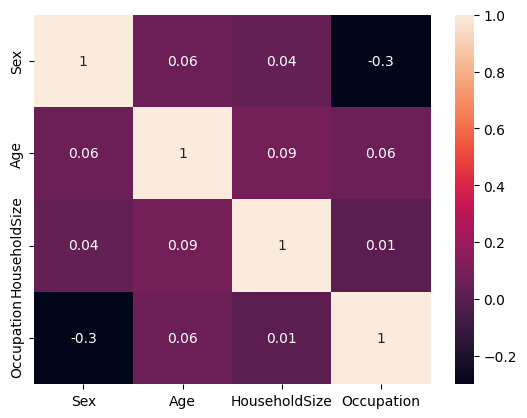

In [6]:
# Pearson coefficients and correlation matrix
df_pearson = data_num.corr(method='pearson', numeric_only=True)
corr_matrix_pear = df_pearson.values.round(decimals=2)
sns.heatmap(corr_matrix_pear, annot=True, xticklabels=col_names, yticklabels=col_names)
plt.show()

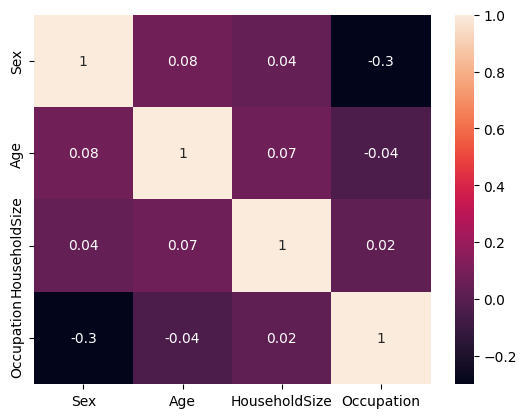

In [7]:
# Kendall coefficients and correlation matrix
df_kendall = data_num.corr(method='kendall', numeric_only=True)
corr_matrix_kendall = df_kendall.values.round(decimals=2)
sns.heatmap(corr_matrix_kendall, annot=True, xticklabels=col_names, yticklabels=col_names)
plt.show()

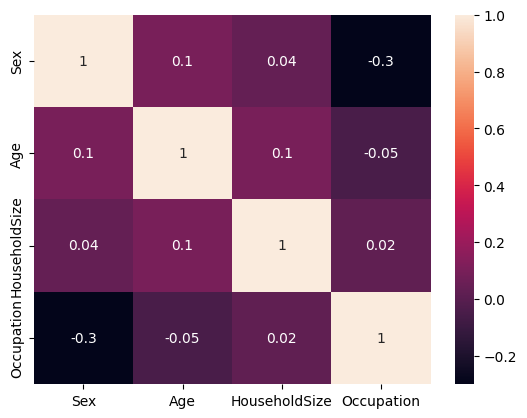

In [8]:
# Spearman coefficients and correlation matrix
df_spearman = data_num.corr(method='spearman', numeric_only=True)
corr_matrix_spear = df_spearman.values.round(decimals=2)
sns.heatmap(corr_matrix_spear, annot=True, xticklabels=col_names, yticklabels=col_names)
plt.show()

### Exploring gender differences
Here, we are going to inspect the data in detail. Let's focus on the gender attribute to detect potential bias. In particular:

- Gender distribution with respect to the target variable (Approved)
- Usual range of values of other variables grouped by gender


In [9]:
# Features of interest
gender_feat = 'Sex'
target_feat = 'Occupation'

In [10]:
# Data frames by gender and approval result
df_female = data[data[gender_feat]==0]
df_male = data[data[gender_feat]==1]

df_female_high = df_female[df_female[target_feat]==1]
df_female_low = df_female[df_female[target_feat]==0]

df_male_high = df_male[df_male[target_feat]==1]
df_male_low = df_male[df_male[target_feat]==0]

In [11]:
# Basic statistics by gender
num_female = df_female.shape[0]
num_male = df_male.shape[0]

num_female_high = df_female_high.shape[0]
num_male_high = df_male_high.shape[0]

perc_female_approved = np.round(num_female_high / num_female * 100, decimals=2)
perc_male_approved = np.round(num_male_high / num_male * 100, decimals=2)

print(f"Num female: {num_female} -> High Occupation: {perc_female_approved}%")
print(f"Num male: {num_male} -> High Occupation: {perc_male_approved}%")

Num female: 30273 -> High Occupation: 67.29%
Num male: 30147 -> High Occupation: 37.44%


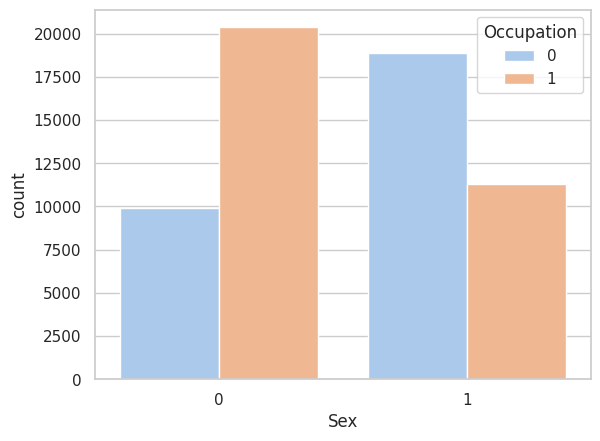

In [12]:
# Plot target variable distribution by gender
sns.set_theme(style='whitegrid', palette='pastel')
sns.countplot(data=data, x=gender_feat, hue=target_feat)
plt.show()

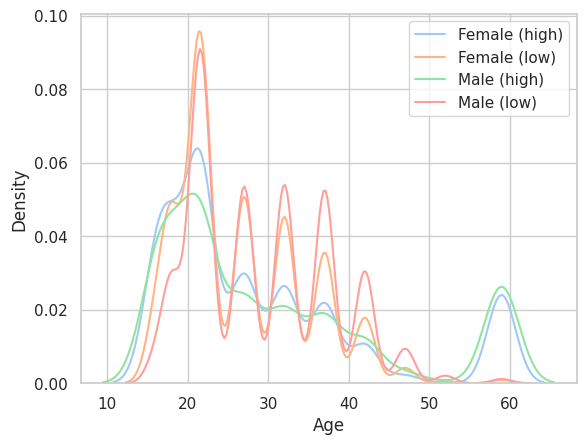

Average age of (female, high): 28.93
Average age of (male, high): 30.61


In [13]:
# Age by gender
feat_name = 'Age'
sns.kdeplot(data=df_female_high[feat_name])
sns.kdeplot(data=df_female_low[feat_name])
sns.kdeplot(data=df_male_high[feat_name])
sns.kdeplot(data=df_male_low[feat_name])
plt.legend(['Female (high)', 'Female (low)', 'Male (high)', 'Male (low)'])
plt.show()

mean_age_female = np.round(np.mean(df_female_high[feat_name]), decimals=2)
mean_age_male = np.round(np.mean(df_male_high[feat_name]), decimals=2)

print(f"Average age of (female, high): {mean_age_female}")
print(f"Average age of (male, high): {mean_age_male}")


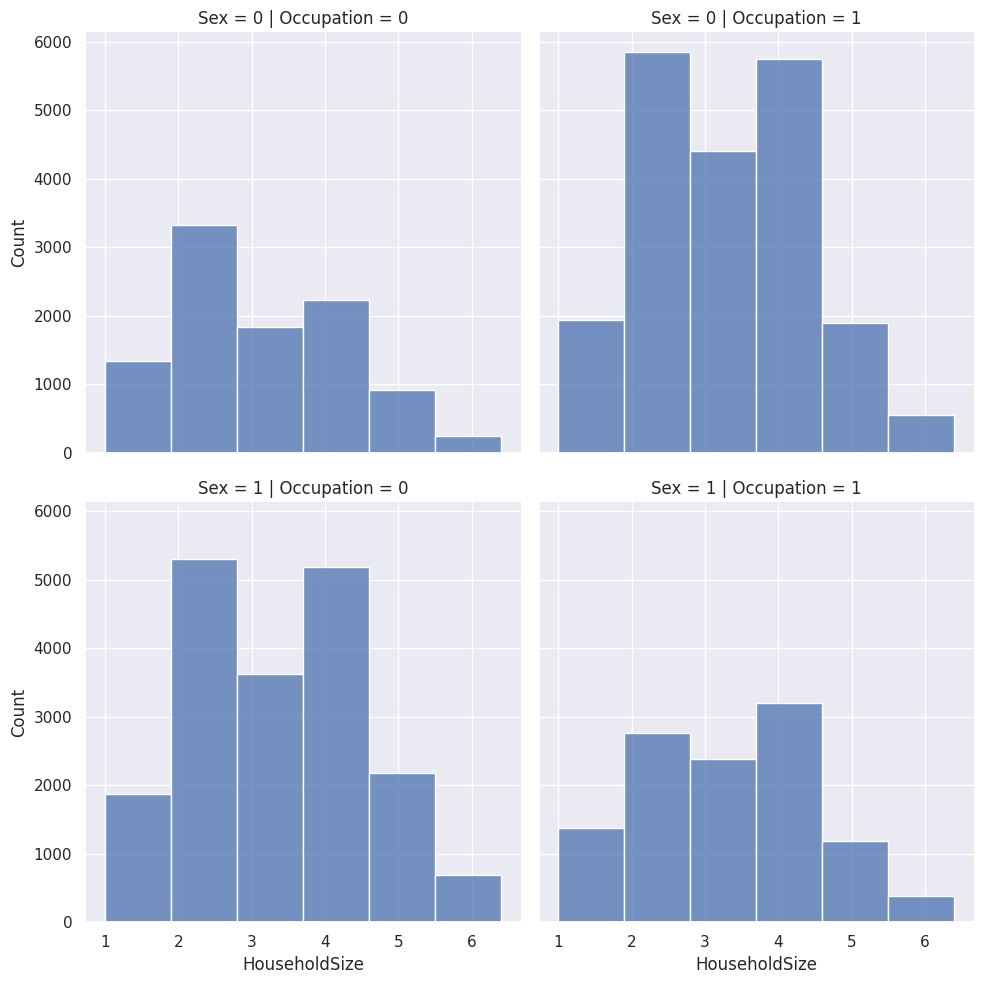

In [14]:
# Household size
sns.set_theme(style='darkgrid')
sns.displot(data=data, x='HouseholdSize', row=gender_feat, col=target_feat, binwidth=0.9, height=5)
plt.show()

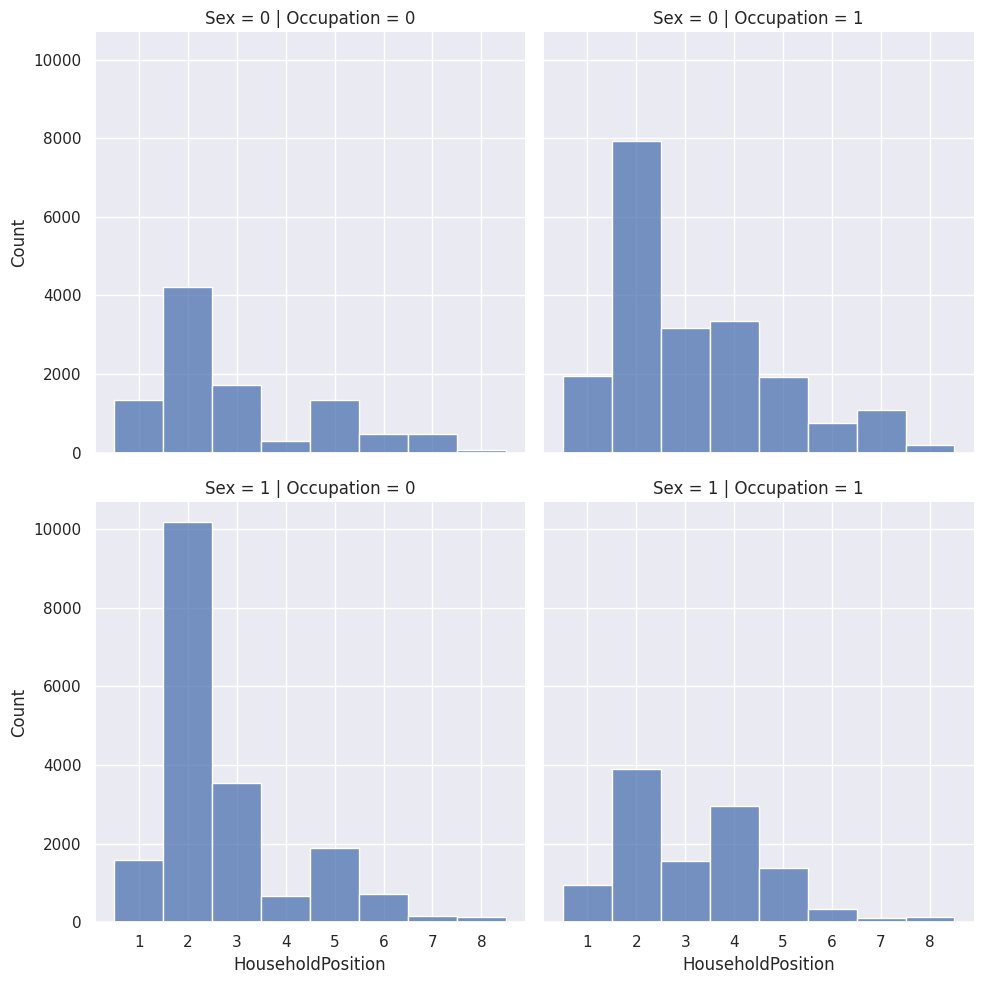

In [15]:
# Household position
sns.displot(data=data, x='HouseholdPosition', row=gender_feat, col=target_feat, binwidth=0.9, height=5)
plt.show()

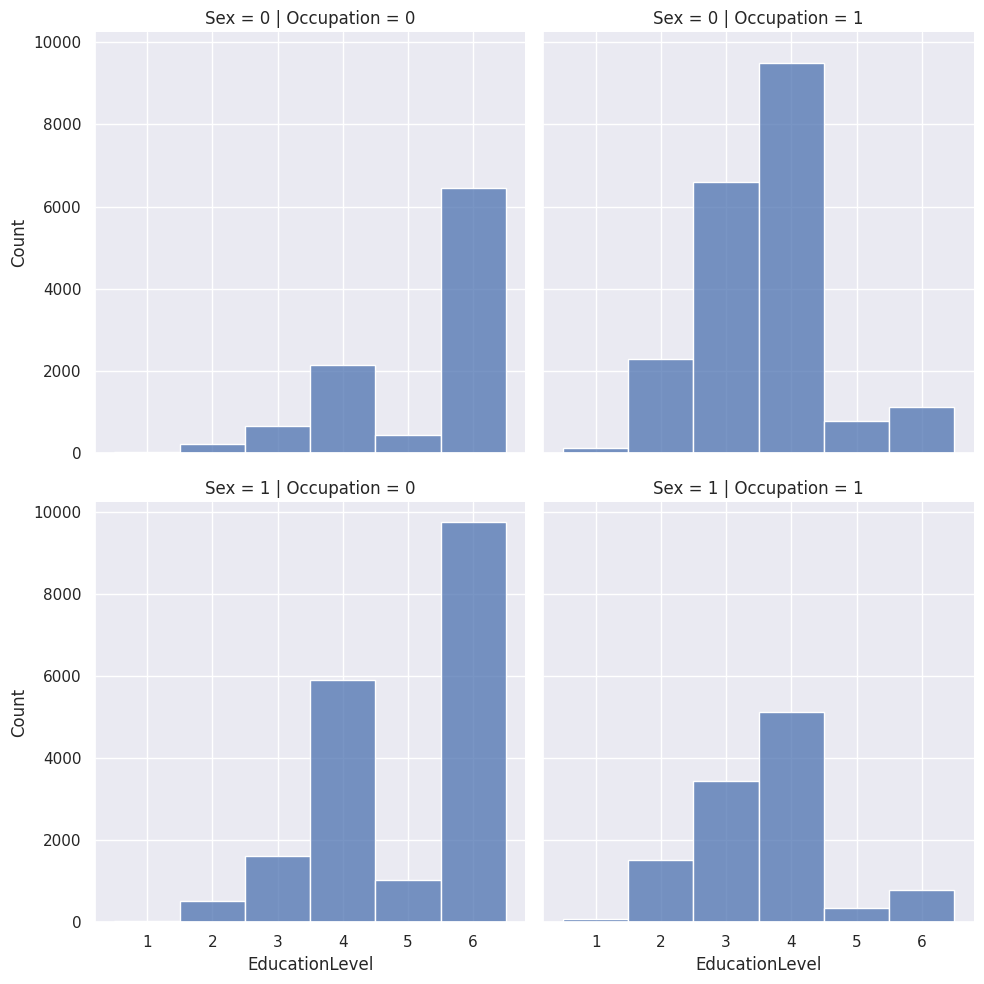

In [16]:
# Education level
sns.displot(data=data, x='EducationLevel', row=gender_feat, col=target_feat, binwidth=0.9, height=5)
plt.show()

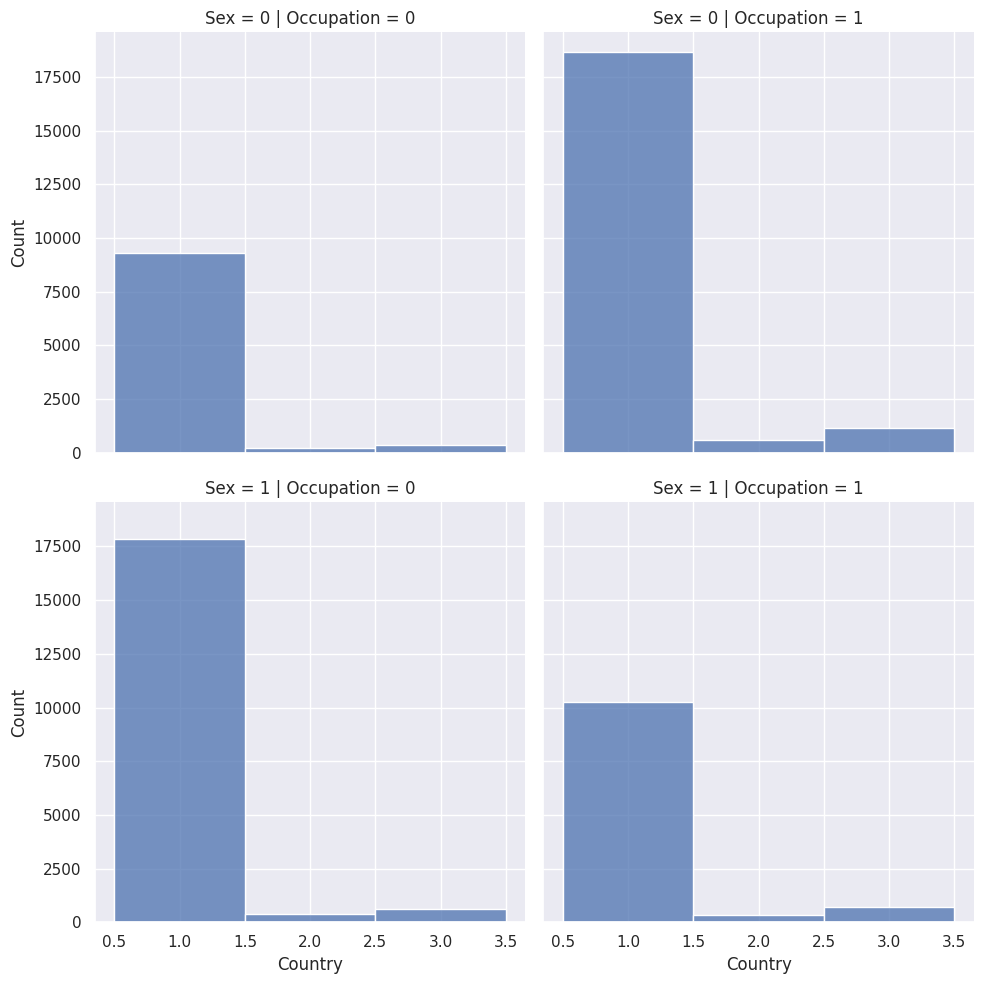

In [17]:
# Country
sns.displot(data=data, x='Country', row=gender_feat, col=target_feat, binwidth=1, height=5)
plt.show()

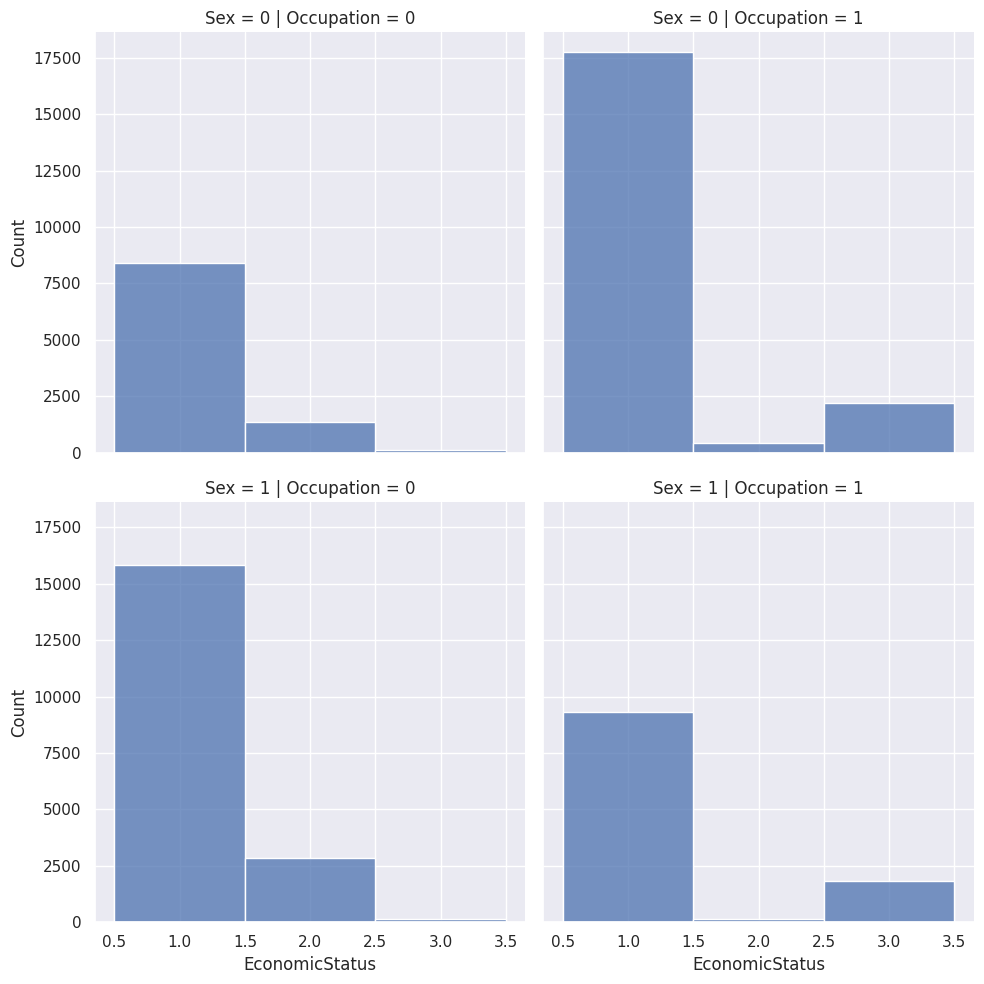

In [18]:
# Economic status
sns.displot(data=data, x='EconomicStatus', row=gender_feat, col=target_feat, binwidth=0.9, height=5)
plt.show()

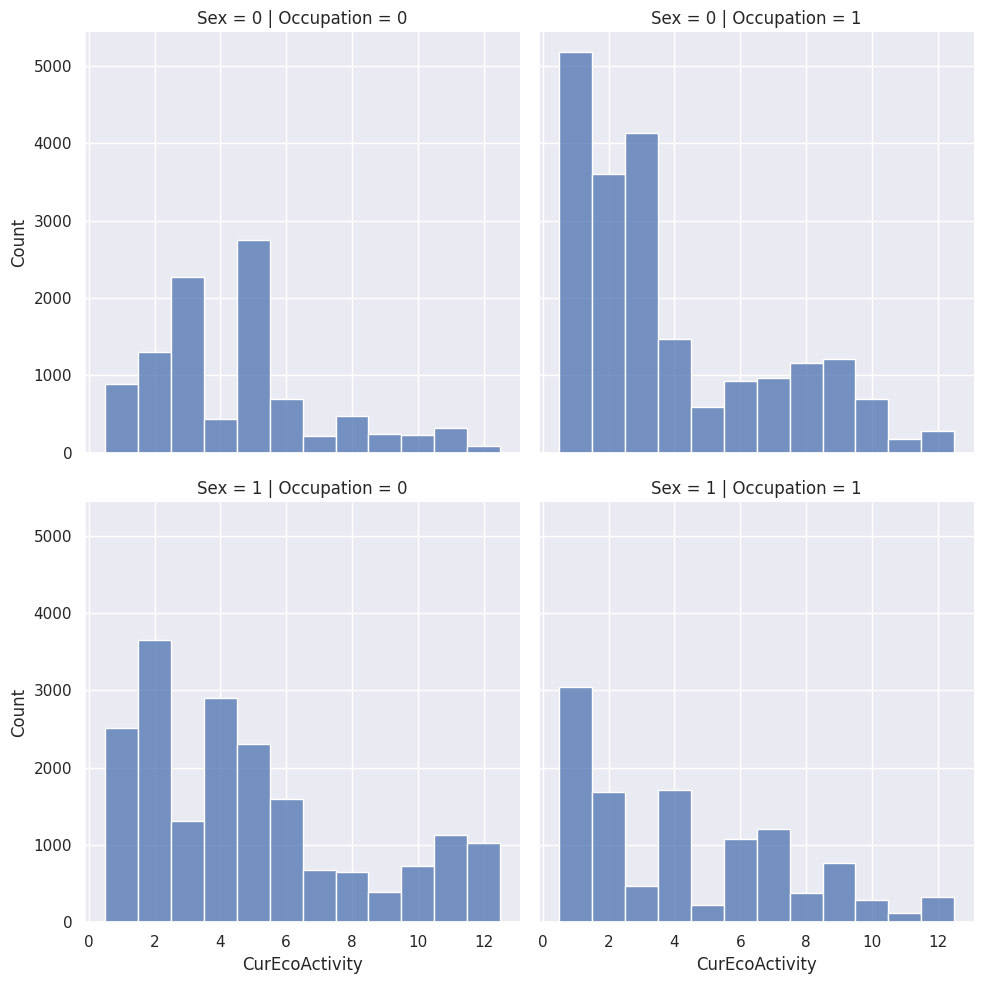

In [19]:
# Current economic activity
sns.displot(data=data, x='CurEcoActivity', row=gender_feat, col=target_feat, binwidth=0.9, height=5)
plt.show()

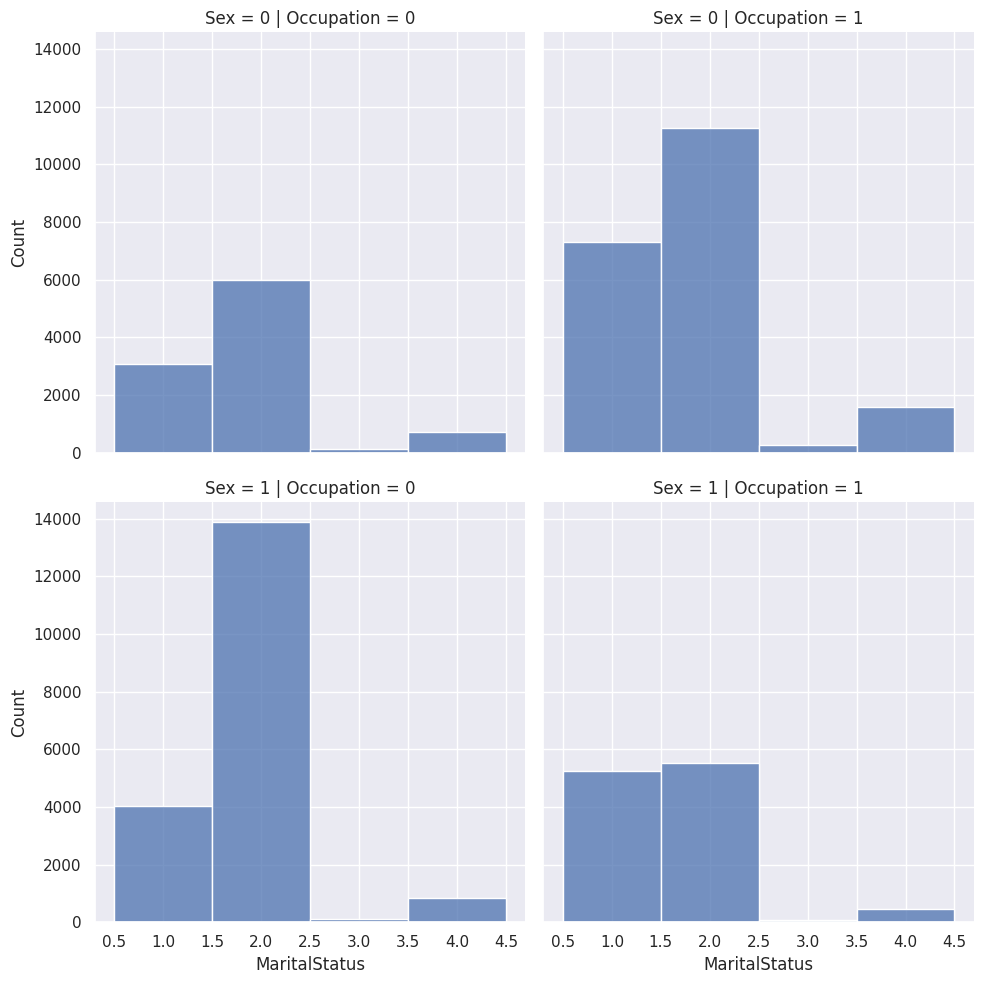

In [20]:
# Marital status
sns.displot(data=data, x='MaritalStatus', row=gender_feat, col=target_feat, binwidth=0.9, height=5)
plt.show()